<a href="https://colab.research.google.com/github/azmiak/Kuliah-Deep-Learning/blob/main/Week%205%20/%20Tugas%20/%20PyTorch_ReviewTokoBaju_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##RNN

In [7]:
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [10]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
df = pd.read_csv("ReviewTokoBaju.csv")
df = df[['Review Text', 'Recommended IND']].dropna()

# Text preprocessing
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['Review Text']).toarray()
X = pad_sequences(X, maxlen=300, padding='post')  # Ensure equal length

# Labels
y = df['Recommended IND'].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
x_train, x_test = torch.tensor(x_train, dtype=torch.long), torch.tensor(x_test, dtype=torch.long)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

In [11]:
# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = ReviewDataset(x_train, y_train)
test_dataset = ReviewDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# RNN model definition
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out

In [15]:
# Model setup
model = RNNModel(vocab_size=5000, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(20):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x).squeeze()
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == y.int()).sum().item()
        train_total += y.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x).squeeze()
            loss = criterion(outputs, y)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(y.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/20] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")

Epoch [1/20] Train Acc: 0.8159, Train Loss: 0.4810 | Test Acc: 0.8207, Test Loss: 0.4770
Epoch [2/20] Train Acc: 0.8184, Train Loss: 0.4774 | Test Acc: 0.8207, Test Loss: 0.4723
Epoch [3/20] Train Acc: 0.8184, Train Loss: 0.4798 | Test Acc: 0.8207, Test Loss: 0.4723
Epoch [4/20] Train Acc: 0.8184, Train Loss: 0.4791 | Test Acc: 0.8207, Test Loss: 0.4707
Epoch [5/20] Train Acc: 0.8184, Train Loss: 0.4792 | Test Acc: 0.8207, Test Loss: 0.4706
Epoch [6/20] Train Acc: 0.8184, Train Loss: 0.4779 | Test Acc: 0.8207, Test Loss: 0.4723
Epoch [7/20] Train Acc: 0.8184, Train Loss: 0.4767 | Test Acc: 0.8207, Test Loss: 0.4749
Epoch [8/20] Train Acc: 0.8184, Train Loss: 0.4786 | Test Acc: 0.8207, Test Loss: 0.4724
Epoch [9/20] Train Acc: 0.8184, Train Loss: 0.4784 | Test Acc: 0.8207, Test Loss: 0.4729
Epoch [10/20] Train Acc: 0.8184, Train Loss: 0.4773 | Test Acc: 0.8207, Test Loss: 0.4707
Epoch [11/20] Train Acc: 0.8184, Train Loss: 0.4776 | Test Acc: 0.8207, Test Loss: 0.4708
Epoch [12/20] Train

Final Training Accuracy: 0.8184
Final Testing Accuracy: 0.8207
Precision: 0.8207
Recall: 1.0000
F1 Squared: 0.8128
AUC: 0.4945


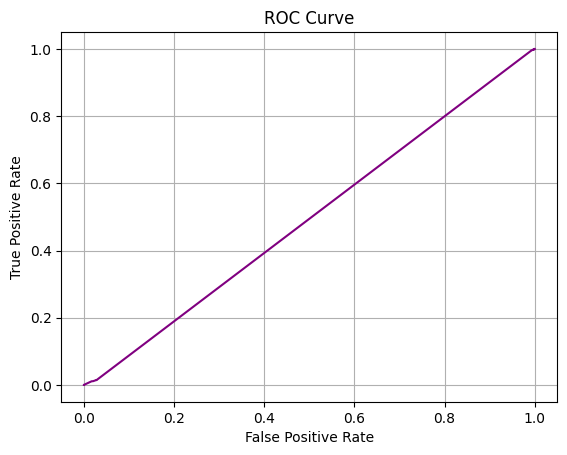

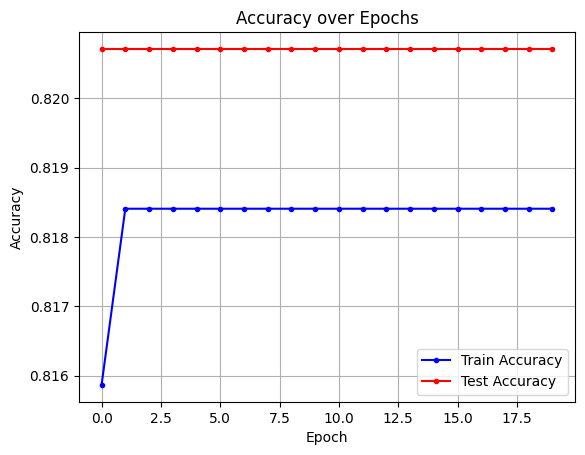

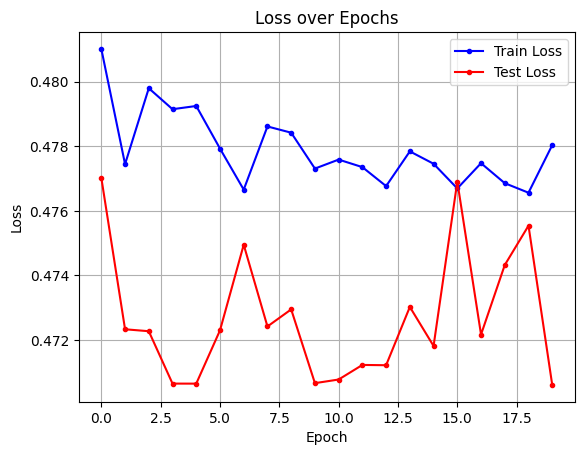

In [21]:
# Evaluation
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve', color='purple')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

# Accuracy graph
plt.figure()
plt.plot(train_acc_list, label="Train Accuracy", color='blue', marker='.')
plt.plot(test_acc_list, label="Test Accuracy", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

# Loss graph
plt.figure()
plt.plot(train_loss_list, label="Train Loss", color='blue', marker='.')
plt.plot(test_loss_list, label="Test Loss", color='red', marker='.')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()